# Hospital Inpatient Discharges (SPARCS De-identified): 2017
Source: New York State Health Department
https://health.data.ny.gov/dataset/Hospital-Inpatient-Discharges-SPARCS-De-Identified/22g3-z7e7

Goal is to predict Risk of Mortality to better inform treatment, aggresivness of approach, expectations of family...

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Using Hospital Inpatient Discharge information for the State of New York from 2017

df= pd.read_csv('Hospital_Inpatient_Discharges__SPARCS_De-Identified___2017.csv', low_memory= False)

In [3]:
print(df.shape)
df.head()

(2343569, 34)


,Hospital Service Area,Hospital County,Operating Certificate Number,Permanent Facility Id,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,...,APR Risk of Mortality,APR Medical Surgical Description,Payment Typology 1,Payment Typology 2,Payment Typology 3,Birth Weight,Abortion Edit Indicator,Emergency Department Indicator,Total Charges,Total Costs
0,Hudson Valley,Westchester,5903001.0,1061.0,Montefiore Mount Vernon Hospital,30 to 49,NaN,M,White,Not Span/Hispanic,...,Minor,Medical,Medicare,Medicare,Self-Pay,NaN,N,N,114168.00,40464.04
1,Hudson Valley,Westchester,5903001.0,1061.0,Montefiore Mount Vernon Hospital,50 to 69,105,M,White,Spanish/Hispanic,...,Moderate,Medical,Medicaid,Medicaid,Self-Pay,NaN,N,N,58517.00,26046.50
2,Hudson Valley,Westchester,5903001.0,1061.0,Montefiore Mount Vernon Hospital,30 to 49,105,F,White,Unknown,...,Moderate,Medical,Department of Corrections,Self-Pay,NaN,NaN,N,N,39647.04,17397.59
3,Hudson Valley,Westchester,5903001.0,1061.0,Montefiore Mount Vernon Hospital,50 to 69,105,F,White,Not Span/Hispanic,...,Moderate,Medical,Medicaid,Medicaid,Self-Pay,NaN,N,N,36031.09,16118.84
4,Hudson Valley,Westchester,5903001.0,1061.0,Montefiore Mount Vernon Hospital,18 to 29,105,F,White,Spanish/Hispanic,...,Minor,Medical,Department of Corrections,Self-Pay,NaN,NaN,N,N,30534.00,11921.05


## Exploration of target

**The target that I want to predict is APR Risk of Mortality.**

This is an important target as it will dictate certain decisions such as treatments, aggresiveness of care, familial preparations for the worst outcome etc...
- Ordinal rank Minor(1), Moderate(2), Major(3), Extreme(4)

It is important to determine this metric early on in the process of treating the patient as this is a crucial piece of information in creating efficient and effective treatment plans for higher risk patients.

As such, while doing feature selection we will consider the timeframe of when certain features are available in order to implement the model earlier in the process.

In [4]:
# Ordinal encode
df['APR Risk of Mortality'] = df['APR Risk of Mortality'].replace({
    'Minor': 1,
    "Moderate": 2,
    "Major": 3,
    "Extreme": 4
})

In [5]:
# Target is 'APR Risk of Mortality'

# Look at target statistics
df['APR Risk of Mortality'].describe()

count    2.343329e+06
mean     1.691481e+00
std      9.164827e-01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      4.000000e+00
Name: APR Risk of Mortality, dtype: float64

In [6]:
# Value counts

df['APR Risk of Mortality'].value_counts()

1.0    1338452
2.0     508068
3.0     378128
4.0     118681
Name: APR Risk of Mortality, dtype: int64

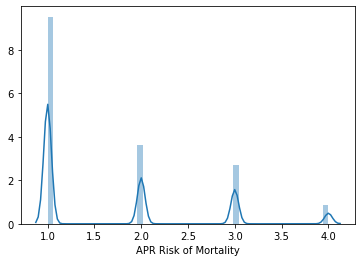

In [7]:
# Visual exploration of the column

import seaborn as sns
import matplotlib.pyplot as plt

sns.distplot(df['APR Risk of Mortality']);

My problem is a multi-class classification

In [8]:
# Distribution of target classes

df['APR Risk of Mortality'].value_counts(normalize= True)

1.0    0.571175
2.0    0.216815
3.0    0.161364
4.0    0.050646
Name: APR Risk of Mortality, dtype: float64

The majority class (1) for my target is is 57%. <br>
I will use accuracy and average f1 score as my evaluation metrics
- Average f1-scores are used for multi-class targets
- Weighted average f1-score will account for the label inbalance in my target

I will use a random split to train/val/test my data as all observations are within the same year. <br>

## Feature Exploration

**Features to exclude** <br>
Not applicable to target (Either unique identifier or information gathered at the end of a patients treatment which is not useful as the model needs to be applied earlier)
- Operating Certificate Number (Unique ID for the hospital)
- Patient Disposition (Destination upon discharge)
- Discharge year (The entire dataset is for the year 2017) 
- Total charges (Information not collected until the end of treatment)
- Total cost (Information not collected until the end of treatment)
- Birth weight (only applicable to newborns)


Redundant: All of the codes have a description column. I will pull them out as a reference table, but for my model they are redundant.
- CCS Diagnosis Description
- CCS Procedure Description
- APR DRG Description
- APR MDC Description


Potential data leakage:
- APR Severity of Illness code (Might have a direct correlation to APR Risk of Mortality)
    - Every time there is a 0 for APR Severity of Illness Code, there is a np.nan for APR Risk of Mortality


Use the below features to create an engineered feature of patient distance to hospital

- Permanent Facility Id
- Facility Name
- Hospital Service Area
- Hospital Country
- Zip code 

## Reference Tables
- Matches descriptions with codes

In [9]:
# Create a reference table for codes and their descriptions
# We will be dropping the descriptions

# CCS Diagnosis
codes_diagnosis = df.groupby('CCS Diagnosis Description')['CCS Diagnosis Code'].mean()
codes_diagnosis = pd.DataFrame(codes_diagnosis)

# CCS Procedure
codes_procedure = df.groupby('CCS Procedure Description')['CCS Procedure Code'].mean()
codes_procedure = pd.DataFrame(codes_procedure)

# APR DRG
codes_drg = df.groupby('APR DRG Description')['APR DRG Code'].mean()
codes_drg = pd.DataFrame(codes_drg)

# APR MDC
codes_mdc = df.groupby('APR MDC Description')['APR MDC Code'].mean()
codes_mdc = pd.DataFrame(codes_mdc)

# APR Severity of Illness
codes_illness = df.groupby('APR Severity of Illness Description')['APR Severity of Illness Code'].mean()
codes_illness = pd.DataFrame(codes_illness)

## Initial Data Cleaning

In [10]:
# Change pandas display so you can see all of the columns at once

pd.set_option('display.max_columns', 25)

In [11]:
# Drop unnecessary features as commented above

df_cleaned = df.drop([
    'Operating Certificate Number',
    'Patient Disposition',
    'Discharge Year',
    'CCS Diagnosis Description',
    'CCS Procedure Description',
    'APR DRG Description',
    'APR MDC Description',
    'Birth Weight',
    'Total Charges',
    'Total Costs',
    'APR Severity of Illness Description'
],
    axis= 1

)
df_cleaned.head()

,Hospital Service Area,Hospital County,Permanent Facility Id,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,Length of Stay,Type of Admission,CCS Diagnosis Code,CCS Procedure Code,APR DRG Code,APR MDC Code,APR Severity of Illness Code,APR Risk of Mortality,APR Medical Surgical Description,Payment Typology 1,Payment Typology 2,Payment Typology 3,Abortion Edit Indicator,Emergency Department Indicator
0,Hudson Valley,Westchester,1061.0,Montefiore Mount Vernon Hospital,30 to 49,NaN,M,White,Not Span/Hispanic,21,Elective,659,0,750,19,2,1.0,Medical,Medicare,Medicare,Self-Pay,N,N
1,Hudson Valley,Westchester,1061.0,Montefiore Mount Vernon Hospital,50 to 69,105,M,White,Spanish/Hispanic,8,Emergency,99,108,194,5,3,2.0,Medical,Medicaid,Medicaid,Self-Pay,N,N
2,Hudson Valley,Westchester,1061.0,Montefiore Mount Vernon Hospital,30 to 49,105,F,White,Unknown,6,Emergency,161,102,465,11,2,2.0,Medical,Department of Corrections,Self-Pay,NaN,N,N
3,Hudson Valley,Westchester,1061.0,Montefiore Mount Vernon Hospital,50 to 69,105,F,White,Not Span/Hispanic,4,Emergency,238,222,721,18,2,2.0,Medical,Medicaid,Medicaid,Self-Pay,N,N
4,Hudson Valley,Westchester,1061.0,Montefiore Mount Vernon Hospital,18 to 29,105,F,White,Spanish/Hispanic,4,Emergency,2,0,720,18,2,1.0,Medical,Department of Corrections,Self-Pay,NaN,N,N


In [12]:
# Look at null values
df_cleaned.isnull().sum()

Hospital Service Area                  5155
Hospital County                        5155
Permanent Facility Id                  5155
Facility Name                             0
Age Group                                 0
Zip Code - 3 digits                   39019
Gender                                    0
Race                                      0
Ethnicity                                 0
Length of Stay                            0
Type of Admission                         0
CCS Diagnosis Code                        0
CCS Procedure Code                        0
APR DRG Code                              0
APR MDC Code                              0
APR Severity of Illness Code              0
APR Risk of Mortality                   240
APR Medical Surgical Description          0
Payment Typology 1                        0
Payment Typology 2                   878722
Payment Typology 3                  1737244
Abortion Edit Indicator                   0
Emergency Department Indicator  

In [13]:
# Explore missing values in target

missing_illness = df[df['APR Risk of Mortality'].isnull() == True]
missing_illness['Type of Admission'].value_counts(normalize = True)

Newborn      0.745833
Emergency    0.120833
Urgent       0.070833
Elective     0.062500
Name: Type of Admission, dtype: float64

In [14]:
# Drop missing values in target (only 0.01%)
# They were mostly (74.5%) newborn babies which we are not including in our model

df_cleaned.dropna(subset= ['APR Risk of Mortality'], inplace= True)

## Data exploration 

In [15]:
# Look at numeric traits
df_cleaned.describe()

,Permanent Facility Id,CCS Diagnosis Code,CCS Procedure Code,APR DRG Code,APR MDC Code,APR Severity of Illness Code,APR Risk of Mortality
count,2.338179e+06,2.343329e+06,2.343329e+06,2.343329e+06,2.343329e+06,2.343329e+06,2.343329e+06
mean,1.038966e+03,1.898662e+02,1.013940e+02,4.161252e+02,1.031172e+01,2.020953e+00,1.691481e+00
std,7.202033e+02,1.649466e+02,8.681344e+01,2.424451e+02,5.899823e+00,8.889587e-01,9.164827e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,5.410000e+02,1.010000e+02,0.000000e+00,1.980000e+02,5.000000e+00,1.000000e+00,1.000000e+00
50%,1.097000e+03,1.570000e+02,9.800000e+01,3.830000e+02,9.000000e+00,2.000000e+00,1.000000e+00
75%,1.453000e+03,2.180000e+02,1.800000e+02,6.400000e+02,1.500000e+01,3.000000e+00,2.000000e+00
max,9.431000e+03,2.617000e+03,2.310000e+02,9.520000e+02,2.500000e+01,4.000000e+00,4.000000e+00


In [16]:
# Look at categorical traits
df_cleaned.describe(exclude= 'number')

,Hospital Service Area,Hospital County,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,Length of Stay,Type of Admission,APR Medical Surgical Description,Payment Typology 1,Payment Typology 2,Payment Typology 3,Abortion Edit Indicator,Emergency Department Indicator
count,2338179,2338179,2343329,2343329,2304316,2343329,2343329,2343329,2343329,2343329,2343329,2343329,1464708,606295,2343329,2343329
unique,8,57,211,5,50,3,4,4,120,6,2,10,10,10,2,2
top,New York City,Manhattan,Mount Sinai Hospital,70 or Older,112,F,White,Not Span/Hispanic,2,Emergency,Medical,Medicare,Medicaid,Self-Pay,N,Y
freq,1070407,395687,52335,664780,293826,1296822,1316956,1895507,546084,1500436,1742545,906899,529653,400972,2339978,1373723


In [17]:
# Look at null values, we will need to impute in the future
df_cleaned.isnull().sum()

Hospital Service Area                  5150
Hospital County                        5150
Permanent Facility Id                  5150
Facility Name                             0
Age Group                                 0
Zip Code - 3 digits                   39013
Gender                                    0
Race                                      0
Ethnicity                                 0
Length of Stay                            0
Type of Admission                         0
CCS Diagnosis Code                        0
CCS Procedure Code                        0
APR DRG Code                              0
APR MDC Code                              0
APR Severity of Illness Code              0
APR Risk of Mortality                     0
APR Medical Surgical Description          0
Payment Typology 1                        0
Payment Typology 2                   878621
Payment Typology 3                  1737034
Abortion Edit Indicator                   0
Emergency Department Indicator  

### Explore relationship between APR Severity of Illness and target for potential data leakage

In [18]:
# Create subset of just the two columns
data_leak = df_cleaned[['APR Severity of Illness Code', 'APR Risk of Mortality']]
data_leak

,APR Severity of Illness Code,APR Risk of Mortality
0,2,1.0
1,3,2.0
2,2,2.0
3,2,2.0
4,2,1.0
...,...,...
2343564,1,2.0
2343565,2,2.0
2343566,1,1.0
2343567,2,1.0


In [19]:
# Look a statistical features
data_leak.describe()

,APR Severity of Illness Code,APR Risk of Mortality
count,2.343329e+06,2.343329e+06
mean,2.020953e+00,1.691481e+00
std,8.889587e-01,9.164827e-01
min,1.000000e+00,1.000000e+00
25%,1.000000e+00,1.000000e+00
50%,2.000000e+00,1.000000e+00
75%,3.000000e+00,2.000000e+00
max,4.000000e+00,4.000000e+00


In [20]:
# Count how many times they are not equivalent

# Convert APR Risk of Mortality to integer
data_leak['APR Risk of Mortality'] = data_leak['APR Risk of Mortality'].astype(int)

# Pull out subset of when the two columns are not equivalent
subset = data_leak[data_leak['APR Risk of Mortality'] != data_leak['APR Severity of Illness Code']]
subset

/Users/stevenchase/opt/anaconda3/envs/yourenvname/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,APR Severity of Illness Code,APR Risk of Mortality
0,2,1
1,3,2
4,2,1
6,2,1
10,2,1
...,...,...
2343561,3,2
2343563,2,1
2343564,1,2
2343567,2,1


In [21]:
# Proportion of when these two columns are the same
1 - len(subset) / len(df_cleaned)

0.5913587037927666

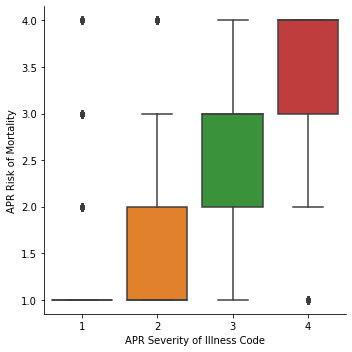

In [22]:
# Visual of relationship
import seaborn as sns
sns.catplot(x= 'APR Severity of Illness Code', y= 'APR Risk of Mortality', kind= 'box', data= data_leak);

## Split into train/val/test using random split

In [23]:
from sklearn.model_selection import train_test_split

# Split train data into train and test, 80/20 split

train, test = train_test_split(df_cleaned, train_size=0.85, test_size=0.15, 
                              stratify=df_cleaned['APR Risk of Mortality'], random_state=42)

# Then split train into train and validate
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['APR Risk of Mortality'], random_state=42)

train.shape, val.shape, test.shape

((1593463, 23), (398366, 23), (351500, 23))

## Baseline model: 
Majority class (1, minor risk) is 57%

In [26]:
df_cleaned['APR Risk of Mortality'].value_counts(normalize= True)

1.0    0.571175
2.0    0.216815
3.0    0.161364
4.0    0.050646
Name: APR Risk of Mortality, dtype: float64

In [27]:
# Baseline classification report
from sklearn.metrics import classification_report

# Looking at weighted average f1-score as an evaluation metric 
guess= [1] * len(df_cleaned)

print(classification_report(df_cleaned['APR Risk of Mortality'], guess))

/Users/stevenchase/opt/anaconda3/envs/yourenvname/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         1.0       0.57      1.00      0.73   1338452
         2.0       0.00      0.00      0.00    508068
         3.0       0.00      0.00      0.00    378128
         4.0       0.00      0.00      0.00    118681

    accuracy                           0.57   2343329
   macro avg       0.14      0.25      0.18   2343329
weighted avg       0.33      0.57      0.42   2343329



## First Model

In [28]:
# Set features and target
# Define target vector and feature matrices

target = 'APR Risk of Mortality'

features = [
    'Age Group',
    'Gender',
    'Race',
    'Ethnicity',
    'Type of Admission',
    'CCS Diagnosis Code',
    'CCS Procedure Code',
    'APR DRG Code',
    'APR MDC Code',
#     'APR Severity of Illness Code',     Removed because of potential data leakage
    'APR Medical Surgical Description',
    'Emergency Department Indicator',
]

# Split into train, validate and test target vector and feature matrices
X_train= train[features]
y_train= train[target]

X_val= val[features]
y_val= val[target]

# Set test feature matrix
X_test= test[features]
y_test= test[target]

In [34]:
# Install category encoders in anaconda environment
# conda install -c conda-forge category_encoders

Solving environment: done

## Package Plan ##

  environment location: /Users/stevenchase/opt/anaconda3/envs/yourenvname

  added / updated specs:
    - category_encoders


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    category_encoders-2.1.0    |             py_0          48 KB  conda-forge
    certifi-2020.4.5.1         |   py37hc8dfbb8_0         151 KB  conda-forge
    openssl-1.1.1g             |       h0b31af3_0         1.9 MB  conda-forge
    python_abi-3.7             |          1_cp37m           4 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.2 MB

The following NEW packages will be INSTALLED:

  category_encoders  conda-forge/noarch::category_encoders-2.1.0-py_0
  python_abi         conda-forge/osx-64::pyth

In [35]:
# Create a pipeline to do encoding and fit a random forest model

# Imports
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Create pipeline (encode, standardize, model)
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    StandardScaler(),
    RandomForestClassifier(random_state= 42, max_depth= 10, n_estimators= 10)
)

# Fit on training data
pipeline.fit(X_train, y_train)

# Validation score
print('Train Accuracy:', pipeline.score(X_train, y_train))
print('Validation Accuracy:', pipeline.score(X_val, y_val))

Train Accuracy: 0.6811472873860266
Validation Accuracy: 0.6788204816676122


#### First model evaluation metric results (With feature APR Severity of Illness Code)
Train Accuracy: 0.7800501172603317 <br>
Validation Accuracy: 0.7783646194705371

#### First model evaluation metric results (Without feature APR Severity of Illness Code)
Train Accuracy: 0.6814384770779114 <br>
Validation Accuracy: 0.6790915891416436

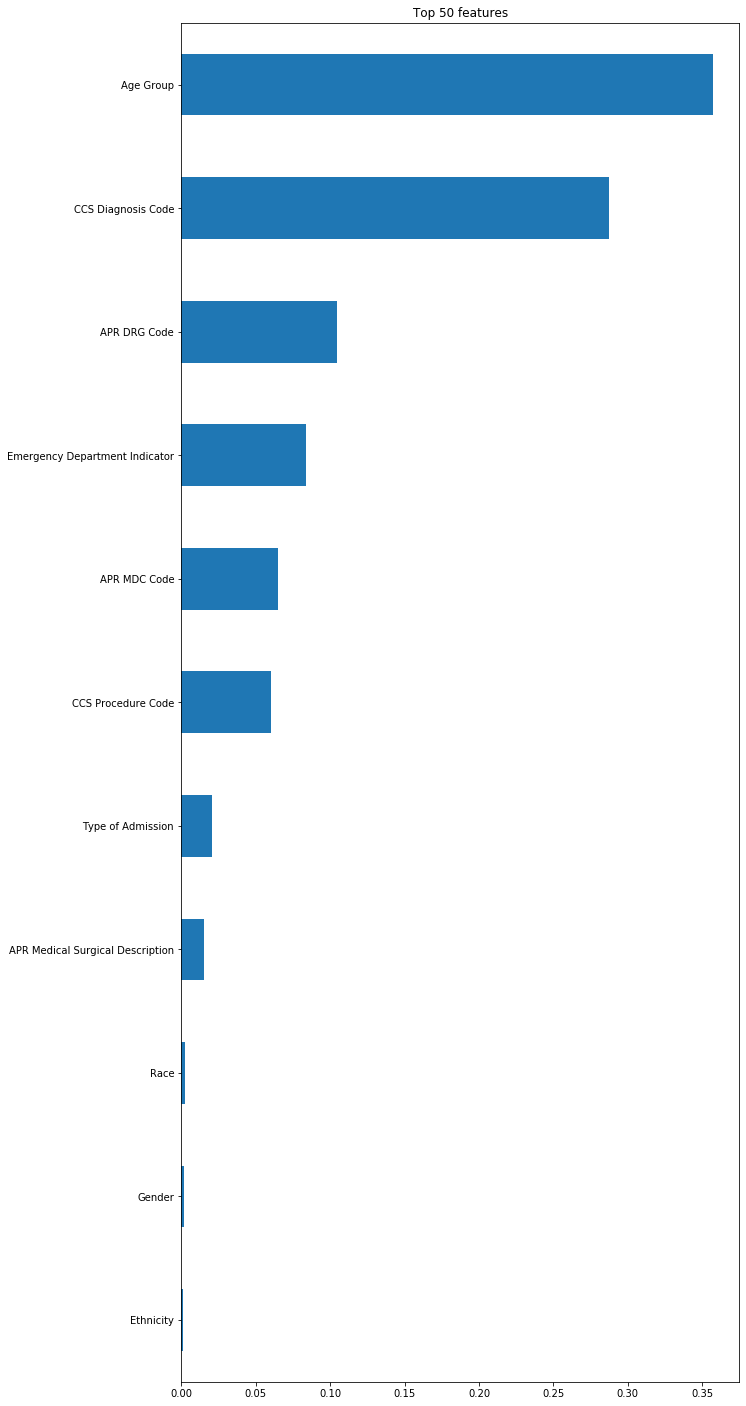

In [36]:
# Feature importances

%matplotlib inline
import matplotlib.pyplot as plt

# Pull out encoded X_train matrix
encoder = pipeline.named_steps['ordinalencoder']
encoded= encoder.transform(X_train)

# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, encoded.columns)

# Plot top n feature importances
n = 50
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();

### Confusion Matrix

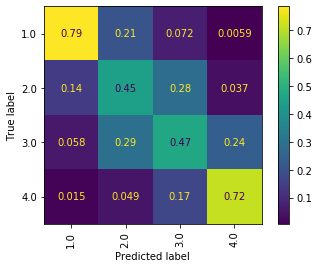

In [37]:
# Confusion matrix
from sklearn.metrics import plot_confusion_matrix

# Plot
plot_confusion_matrix(pipeline, X_val, y_val, xticks_rotation= 'vertical', normalize= 'pred')

# Enlarge
plt.rcParams['figure.dpi']= 200

### Scores for Model 1

In [38]:
# Look at precision and recall for each class
# Using weighted average f1-score as an evaluation metric

from sklearn.metrics import classification_report

# Make predictions
y_pred= pipeline.predict(X_val)

# Print scores
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         1.0       0.79      0.91      0.85    227537
         2.0       0.45      0.38      0.41     86371
         3.0       0.47      0.41      0.44     64282
         4.0       0.72      0.16      0.26     20176

    accuracy                           0.68    398366
   macro avg       0.61      0.47      0.49    398366
weighted avg       0.66      0.68      0.66    398366



Remember that the baseline model had an accuracy of 57% with a weighted average f1-score of 0.42

## Model 2
- Include all of the features except for geographic data

In [39]:
# Look at label names for spelling mistakes etc...
df_cleaned['Emergency Department Indicator'].value_counts().index.tolist()

['Y', 'N']

In [40]:
# Set features and target
# Define target vector and feature matrices

# Including all features except for target and geographic data

target = 'APR Risk of Mortality'

features = [
    'Age Group',
    'Gender',
    'Race',
    'Ethnicity',
    'Length of Stay',
    'Type of Admission',
    'CCS Diagnosis Code',
    'CCS Procedure Code',
    'APR DRG Code',
    'APR MDC Code',
#     'APR Severity of Illness Code',    Removed for potential data leakage
    'APR Medical Surgical Description',
    'Payment Typology 1',
    'Payment Typology 2',
    'Payment Typology 3',
    'Abortion Edit Indicator',
    'Emergency Department Indicator',
]

# Split into train, validate and test target vector and feature matrices
X_train= train[features]
y_train= train[target]

X_val= val[features]
y_val= val[target]

# Set test feature matrix
X_test= test[features]
y_test= test[target]

In [41]:
# Create a function to clean data the same way

def clean(X):
    
# Prevent SettingWithCopyWarning - create a copy
    X = X.copy()
    
# Replace missing values of Payment Typology 2 and 3 with 'None', they only used one type of payment
    X['Payment Typology 2']= X['Payment Typology 2'].replace({np.nan: 'None'})
    X['Payment Typology 3']= X['Payment Typology 3'].replace({np.nan: 'None'})

# Return cleaned dataset    
    return X

In [42]:
# Clean train, val, test 

X_train= clean(X_train)

X_val= clean(X_val)

X_test= clean(X_test)

In [43]:
# Create a pipeline to do encoding and fit a random forest model

# Imports
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Create pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    StandardScaler(),
    RandomForestClassifier(random_state= 42, max_depth= 20, n_estimators= 30, n_jobs= -1)
)

# Fit pipeline on training data
pipeline.fit(X_train, y_train)

# Validation score
print('Train Accuracy:', pipeline.score(X_train, y_train))
print('Validation Accuracy:', pipeline.score(X_val, y_val))

Train Accuracy: 0.8065747369094858
Validation Accuracy: 0.7035464874010332


### Scores for Model 2

In [44]:
# Make predictions
y_pred= pipeline.predict(X_val)

# Print recall, precision and f1 scores
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         1.0       0.84      0.90      0.87    227537
         2.0       0.47      0.44      0.46     86371
         3.0       0.50      0.49      0.49     64282
         4.0       0.61      0.27      0.38     20176

    accuracy                           0.70    398366
   macro avg       0.60      0.53      0.55    398366
weighted avg       0.69      0.70      0.69    398366



Including all of the features bumped the evaluation scores up 2-3 points each.

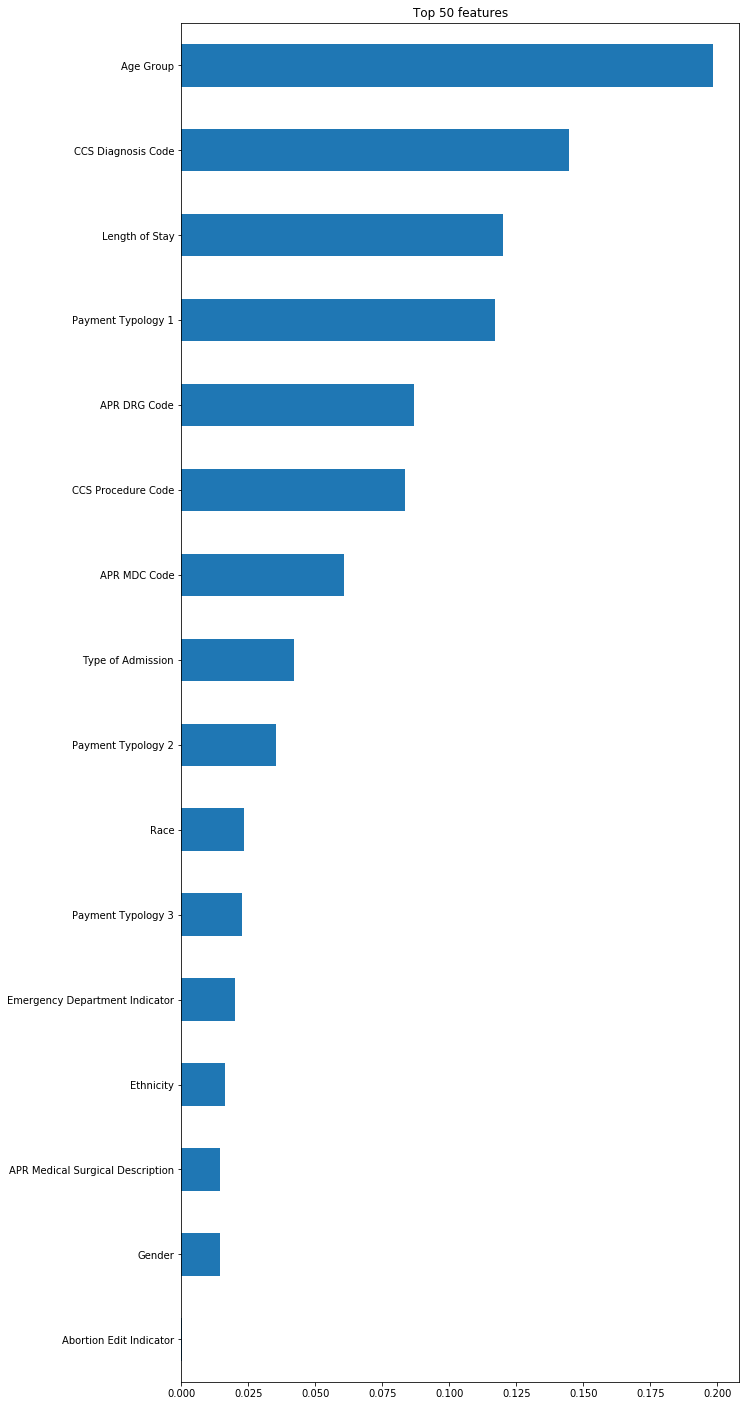

In [45]:
# Feature importances

%matplotlib inline
import matplotlib.pyplot as plt

# Pull out encoded X_train matrix
encoder = pipeline.named_steps['ordinalencoder']
encoded= encoder.transform(X_train)

# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, encoded.columns)

# Plot top n feature importances
n = 50
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();

#### Permutation importances

In [46]:
# You can't use a pipeline in eli5
# Need to transform data and fit model before inputting into PermutationImportance

# Create pipeline to transform data
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    StandardScaler()
)

# Transform the data
X_train_transformed = pipeline.fit_transform(X_train)
X_val_transformed = pipeline.transform(X_val)

# Define model with parameters
model = RandomForestClassifier(random_state= 42, max_depth= 20, n_estimators= 30, n_jobs= -1)

# Fit the model to train data
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [50]:
# Install eli5 on anaconda environment
# conda install -c conda-forge eli5

Solving environment: done

## Package Plan ##

  environment location: /Users/stevenchase/opt/anaconda3/envs/yourenvname

  added / updated specs:
    - eli5


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    cairo-1.16.0               |    h0ab9d94_1001         1.3 MB  conda-forge
    eli5-0.10.1                |           py37_1         135 KB  conda-forge
    fontconfig-2.13.1          |    h1027ab8_1000         269 KB  conda-forge
    fribidi-1.0.9              |       h0b31af3_0          64 KB  conda-forge
    graphite2-1.3.13           |    h2098e52_1000          84 KB  conda-forge
    graphviz-2.40.1            |       hefbbd9a_2         6.3 MB
    harfbuzz-1.8.8             |       hb8d4a28_0         414 KB
    pango-1.42.4               |       h060686c_0         455 KB
    pixman-0.38.0              |    h01d97ff_1003         611 KB  conda-forge
    python-graphviz-0.13.2     | 

In [51]:
# Import
import eli5
from eli5.sklearn import PermutationImportance

# Define permuter and parameters
permuter= PermutationImportance(model, scoring= 'accuracy', n_iter= 5, random_state= 42)

# Fit permutation importance to transformed validation data
permuter.fit(X_val_transformed, y_val)

/Users/stevenchase/opt/anaconda3/envs/yourenvname/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/stevenchase/opt/anaconda3/envs/yourenvname/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=20,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_frac

In [52]:
# Show weights graphic

# Define feature labels
feature_labels = X_val.columns.tolist()

# Run and print function
eli5.show_weights(permuter, top= None, feature_names= feature_labels)

Weight,Feature
0.0710 ± 0.0008,Age Group
0.0400 ± 0.0007,CCS Diagnosis Code
0.0385 ± 0.0006,Length of Stay
0.0209 ± 0.0006,APR DRG Code
0.0202 ± 0.0005,CCS Procedure Code
0.0136 ± 0.0005,APR MDC Code
0.0095 ± 0.0004,Payment Typology 1
0.0080 ± 0.0003,APR Medical Surgical Description
0.0045 ± 0.0003,Type of Admission
0.0041 ± 0.0004,Emergency Department Indicator


### XGBoost

In [54]:
# Import
from xgboost import XGBClassifier

# Create pipeline using XGBoostClassifier
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    StandardScaler(),
    XGBClassifier(n_estimators= 30, random_state= 42, n_jobs= -1)
)

# Fit pipeline to train data
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Age Group', 'Gender', 'Race',
                                      'Ethnicity', 'Length of Stay',
                                      'Type of Admission',
                                      'APR Medical Surgical Description',
                                      'Payment Typology 1',
                                      'Payment Typology 2',
                                      'Payment Typology 3',
                                      'Abortion Edit Indicator',
                                      'Emergency Department Indicator'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value'...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
  

In [55]:
# Import
from sklearn.metrics import accuracy_score

# Make predictions
y_pred= pipeline.predict(X_val)

# Print error metric
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.6711491442542787


In [56]:
# Print recall, precision and f1 scores
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         1.0       0.77      0.92      0.84    227537
         2.0       0.44      0.34      0.38     86371
         3.0       0.47      0.39      0.43     64282
         4.0       0.65      0.13      0.21     20176

    accuracy                           0.67    398366
   macro avg       0.58      0.45      0.47    398366
weighted avg       0.64      0.67      0.64    398366



XGBoost did not improve the evaluation metrics from random forest

## Model 3
- Feature engineer: distance to hospital
- Feature engineer: did they require multiple methods of payment
- Clean up feature selection. Don't include ones that have low importance in the model

In [ ]:
df_cleaned.head()

In [ ]:
df_cleaned.describe(exclude= 'number')

In [ ]:
df_cleaned.describe()

In [ ]:
df_cleaned.isnull().sum()